<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/import-py-files/src/code/TC_Category_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones
%ls

import imp 
# import helper.py
helper = imp.new_module('helper_functions')
exec(open("./helper_functions.py").read(), helper.__dict__)
# import models.py
models = imp.new_module('models')
exec(open("./models.py").read(), models.__dict__)
# import data_processor.py
dp = imp.new_module('data_processor')
exec(open("./data_processor.py").read(), dp.__dict__)

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones
 data/                             'TC_downloader_&_converter.ipynb'
 data_processor.py                  TC_Eye_Detection.ipynb
 helper_functions.py                TC_GradCAM.ipynb
 Meetings/                          TC_model_comparison.ipynb
 models.py                          TC_parametric_model.ipynb
 TC_best_tracks.ipynb               TC_Vmax_Regression.ipynb
 TC_Category_Classification.ipynb


In [3]:
# insert your desired path to work on
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
%ls

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
best_track/                            SAR_swath_images@
categorisation.png                     SAR_swath_images_VV+VH+VH/
classification_results/                SAR_swath_images_VV+VH+WS/
identification.png                     SAR_swath_images_WS+sWSO+cWSO/
model_comparisons_between_datasets/    SAR_swath_images_WS+WS+WS/
model.png                              SAR_swath_masks/
parametric_model/                      SAR_swath_nc/
SAR_IMAGE_DATASET_EYE_CLASSIFICATION@  SAR_swath_Vmax/


In [4]:
# general imports
import random
import glob
import os
import sys
sys.stdout.flush()
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import imageio
import os.path
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from google.colab.patches import cv2_imshow
import random
from shapely.geometry import Point
import re
import pickle
import scipy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import Dataset
from tensorflow.keras import Input
from tensorflow.keras.applications import resnet50, mobilenet_v2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(precision=4)

## Train on data according to csv split into train, val and test sets.

Prepare the tf.data.Dataset instances to be fed to the model.

In [ ]:
##################################
###          SETTINGS         ####
##################################
main_dir = "SAR_swath_images_VV+VH+WS"
NETWORK = "ResNet"     # options: ["Mobile", "ResNet"]
MIN_HEIGHT = 288
MIN_WIDTH = 288
NUM_VARS = False
NORMALISE = True
ROTATE = False
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 20
LEARNING_RATE = 0.0001
##################################

# load data
train_images, train_labels, train_bbox = helper.load_data_with_cat("{}/csv/training.csv".format(main_dir))
val_images, val_labels, val_bbox = helper.load_data_with_cat("{}/csv/val.csv".format(main_dir))
test_images, test_labels, test_bbox = helper.load_data_with_cat("{}/csv/test.csv".format(main_dir))
class_weights = helper.compute_class_weights("{}/csv/full_dataset.csv".format(main_dir))


# create an instance of the DataProcessor
processor = dp.DataProcessor(model = NETWORK,
                             min_height = MIN_HEIGHT,
                             min_width = MIN_WIDTH,
                             normalise = False,           # perform normalisation
                             rotate = ROTATE,                 # perform rotation
                             plot_light = False,              # plot only select_crop() images
                             plot_extensive = False,          # plot extensively all images
                             show_prints = False)


# generate datasets
train_dataset = helper.prepare_dataset(processor, train_images, train_labels, train_bbox)
val_dataset = helper.prepare_dataset(processor, val_images, val_labels, val_bbox)
test_dataset = helper.prepare_dataset(processor, test_images, test_labels, test_bbox)
#for image, label in train_dataset:
#  plt.imshow(image)
#  plt.show()
#  print("FINAL - image: {}, label: {}".format(image.shape, label))
#  print("FINAL - image: {}, max: {}, min: {}, label: {}".format(image.shape, np.max(image), np.min(image),  label))

train_dataset, val_dataset = helper.z_norm(train_dataset, val_dataset)
#cnt = 0
#for image, label in train_dataset:
#  cnt +=1
#  plt.imshow(image)
#  plt.show()

# configure for performance
train_dataset = helper.configure_for_performance(train_dataset, BUFFER_SIZE, BATCH_SIZE, shuffle = True, augment = True)
val_dataset = helper.configure_for_performance(val_dataset, BUFFER_SIZE, BATCH_SIZE)
test_dataset = helper.configure_for_performance(test_dataset, BUFFER_SIZE, BATCH_SIZE)

Script to perform end-to-end training in the model.

In [ ]:
# directory to save results
dir = '{}_Numeric-{}_BatchSize-{}_Epochs-{}_Norm-{}'.format(NETWORK, str(NUM_VARS)[0], str(BATCH_SIZE), str(EPOCHS), str(NORMALISE)[0])
save_dir = 'classification_results/categorization/' + dir + '/'
os.makedirs(save_dir, exist_ok=True)

# MAKE MODEL
if NETWORK == "Mobile":
  model = models.make_MobileNet(MIN_WIDTH, MIN_HEIGHT, LEARNING_RATE)
elif NETWORK == "ResNet":
  model = models.make_ResNet(MIN_WIDTH, MIN_HEIGHT, LEARNING_RATE)
else:
  sys.exit("Incert valid network model. Options: Mobile or ResNet (case sensitive)")

# CREATE CALLBACKS
callbacks = [
    EarlyStopping(patience = 7, verbose = 1),
    ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = 0.00001, verbose = 1),
    ModelCheckpoint(save_dir + "best_model.h5", verbose = 1, save_best_only = True),
    TensorBoard(log_dir = save_dir + "logs/" + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
]

# TRAIN THE NETWORK
H = model.fit(
    train_dataset,
    steps_per_epoch = len(train_dataset),
    validation_data = val_dataset,
    validation_steps = len(val_dataset),
    epochs = EPOCHS,
    callbacks = callbacks,
    verbose = 1,
    class_weight = class_weights,
    shuffle = True)

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir classification_results/categorization/ResNet_Numeric-F_BatchSize-8_Epochs-20_Norm-T/logs

In [ ]:
# EVALUATE MODEL
print("Loaded best weights of the training")
model.load_weights(save_dir + "best_model.h5")

results = model.evaluate(test_dataset, 
                         steps = len(test_dataset), 
                         verbose = 1)

In [ ]:
# MAKE PREDICTIONS
# Retrieve a batch of images from the test set
predictions = model.predict(test_dataset.)

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n')
for label in test_labels_dataset:
  print(label)
#class_names = {0: "No eye", 1: "Eye"}
#plt.figure(figsize=(10, 10))
#for i in range(9):
#  ax = plt.subplot(3, 3, i + 1)
#  plt.imshow(image_batch[i].astype("uint8"))
#  plt.title(class_names[predictions[i]])
#  plt.axis("off")

## Train on data using the Stratified K Fold.

In [ ]:
##################################
###          SETTINGS         ####
##################################
main_dir = "SAR_swath_images_VV+VH+WS"
NETWORK = "ResNet"     # options: ["Mobile", "ResNet"]
MIN_HEIGHT = 288
MIN_WIDTH = 288
NUM_VARS = False
NORMALISE = True
ROTATE = False
AUGMENT = True
BATCH_SIZE = 16
BUFFER_SIZE = 100
EPOCHS = 3
FOLDS = 5
LEARNING_RATE = 0.0001
##################################

# STRATIFIED CROSS VALIDATION
def fold_cross_validation(main_dir, NETWORK, MIN_HEIGHT, MIN_WIDTH, NUM_VARS, NORMALISE, ROTATE, AUGMENT, LEARNING_RATE, EPOCHS, BUFFER_SIZE, BATCH_SIZE, SPLIT_NUMBER):

  df = pd.read_csv(main_dir + "/csv/full_dataset.csv", converters={'bbox_shape': eval}).dropna()
  class_weights = helper.compute_class_weights("{}/csv/full_dataset.csv".format(main_dir))

  #Y = df["label"]
  Y = np.zeros(len(df), dtype=int)
  for index, row in df.iterrows():
    if df["label"][index] != 0:
      cat = df["image"][index].split('/')[1]
      Y[index] = int(cat[-1])

  stratified_k_fold = StratifiedKFold(n_splits = SPLIT_NUMBER, random_state = 42, shuffle = False)

  VALIDATION_ACCURACY = []
  VALIDATION_LOSS = []
  VALIDATION_TP = []
  VALIDATION_FP = []
  VALIDATION_TN = []
  VALIDATION_FN = []
  VALIDATION_PRECISION = []
  VALIDATION_RECALL = []

  print("Entering in k fold cross validation")
  print("Dataset dim: {}".format(len(df)))

  # directory to save results
  dir = '{}_Numeric-{}_BatchSize-{}_{}x{}_lr-{}_Epochs-{}_Folds-{}_Norm-z{}_Aug-4{}_randomCrops_withoutclassweights'.format(NETWORK, str(NUM_VARS)[0], BATCH_SIZE, MIN_HEIGHT, MIN_WIDTH, LEARNING_RATE, EPOCHS, SPLIT_NUMBER, str(NORMALISE)[0], str(AUGMENT)[0])
  save_dir = main_dir + '/classification_results/categorization/test677/' + dir + '/'
  fold_var = 1
  
  # create an instance of the DataProcessor
  processor = dp.DataProcessor(model = NETWORK,
                               min_height = MIN_HEIGHT,
                               min_width = MIN_WIDTH,
                               normalise = False,           # perform normalisation
                               rotate = ROTATE,                 # perform rotation
                               plot_light = False,              # plot only select_crop() images
                               plot_extensive = False,          # plot extensively all images
                               show_prints = False)


  for train_index, val_index in stratified_k_fold.split(np.zeros(len(df)), Y):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]

    train_images, train_labels, train_bbox = helper.load_from_df_with_cat(training_data)
    val_images, val_labels, val_bbox = helper.load_from_df_with_cat(validation_data)
    
    # generate datasets
    #train_dataset = helper.prepare_dataset(processor, train_images, train_labels, train_bbox)
    #val_dataset = helper.prepare_dataset(processor, val_images, val_labels, val_bbox)
    train_dataset = helper.create_dataset(processor, 5, train_images, train_labels, train_bbox)
    val_dataset = helper.create_dataset(processor, 5, val_images, val_labels, val_bbox)

    val_labels = val_dataset.map(lambda x, y: y)

    # perform z-normalisation to the images
    train_dataset, val_dataset = helper.z_norm(train_dataset, val_dataset)

    # configure for performance
    train_dataset = helper.configure_for_performance(train_dataset, BUFFER_SIZE, BATCH_SIZE, shuffle = True, augment = AUGMENT)
    val_dataset = helper.configure_for_performance(val_dataset, BUFFER_SIZE, BATCH_SIZE)

    # CREATE NEW MODEL
    """
    # multi GPU strategy
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        model = make_resNet(IMG_SIZE, start_from_scratch=True)
    """
    if NETWORK == "Mobile":
      model = models.make_MobileNet(MIN_WIDTH, MIN_HEIGHT, LEARNING_RATE)
    elif NETWORK == "ResNet":
      model = models.make_ResNet(MIN_WIDTH, MIN_HEIGHT, LEARNING_RATE)
    else:
      sys.exit("Incert valid network model. Options: Mobile or ResNet (case sensitive)")

    # CREATE CALLBACKS
    callbacks = [
        #EarlyStopping(patience = 10, verbose = 1),
        ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = 0.00001, verbose = 1),
        ModelCheckpoint(save_dir + helper.get_model_name(fold_var), verbose = 1, save_best_only = True),
        TensorBoard(log_dir = save_dir + "logs/" + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    ]

    # FIT THE MODEL
    history = model.fit(
        train_dataset,
        steps_per_epoch = len(train_dataset),
        validation_data = val_dataset,
        validation_steps = len(val_dataset), 
        epochs = EPOCHS,
        callbacks = callbacks,
        verbose = 1, 
        #class_weight = class_weights,
        shuffle = True)
    
    # PLOT HISTORY
    #print(history)


    # PLOT TRAIN/VALIDATION LOSSES
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 10))
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set(ylabel = "Accuracy",
            title = 'Training and Validation Accuracy')

    ax2.plot(history.history["loss"], label='Training Loss')
    ax2.plot(history.history["val_loss"], label='Validation Loss')
    ax2.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label = "Best model")
    ax2.grid(True)
    ax2.legend(loc='upper right')
    ax2.set(xlabel = 'Epoch', 
          ylabel = 'Cross Entropy',
          title = 'Training and Validation Loss')
    plt.show()
    fig.savefig(save_dir + "model_" + str(fold_var) + ".jpg")

    
    time.sleep(10) # guarantees enough time so that weights are saved and can be loaded after

    # LOAD BEST MODEL
    print("Loaded best weights of the training")
    model.load_weights(save_dir + helper.get_model_name(fold_var))     # Maybe a problem with colab, weights saved and loaded too fast giving concurrency problems

    # EVALUATE PERFORMANCE of the model
    results = model.evaluate(val_dataset, 
                             steps = len(val_dataset), 
                             verbose = 1)

    results = dict(zip(model.metrics_names, results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_TP.append(results["tp"])
    VALIDATION_FP.append(results["fp"])
    VALIDATION_TN.append(results["tn"])
    VALIDATION_FN.append(results["fn"])
    VALIDATION_PRECISION.append(results["precision"])
    VALIDATION_RECALL.append(results["recall"])

    # MAKE PREDICTIONS
    predictions = model.predict(val_dataset)
    predictions_non_category = [ np.argmax(t) for t in predictions ]
    val_labels_non_category = [ np.argmax(t) for t in val_labels ]

    conf_mat = confusion_matrix(val_labels_non_category, predictions_non_category, labels = [0,1,2,3,4,5])
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1,2,3,4,5])
    conf_mat_display = disp.plot()
    plt.savefig(save_dir + "confusion_matrix_" + str(fold_var) + ".jpg")

    tf.keras.backend.clear_session()

    fold_var += 1

    # save the values for each fold
    csv_dir = save_dir + 'csv/'
    os.makedirs(csv_dir, exist_ok=True)
    with open(csv_dir + 'test_accuracy.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_ACCURACY, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_loss.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_LOSS, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_tp.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_TP, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_fp.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_FP, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_tn.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_TN, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_fn.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_FN, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_precision.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_PRECISION, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_recall.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_RECALL, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return

#######################################
# test
fold_cross_validation(main_dir, NETWORK, MIN_HEIGHT, MIN_WIDTH, NUM_VARS, NORMALISE, ROTATE, AUGMENT, LEARNING_RATE, EPOCHS, BUFFER_SIZE, BATCH_SIZE, FOLDS)

## Perform Fine-Tuning

### Using the csv split into train, val and test sets.

In [ ]:
##################################
###          SETTINGS         ####
##################################
main_dir = "SAR_swath_images_VV+VH+WS"
NETWORK = "ResNet"     # options: ["Mobile", "ResNet"]
MIN_HEIGHT = 700
MIN_WIDTH = 400
NUM_VARS = False
NORMALISE = True
ROTATE = False
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 50
LEARNING_RATE = 0.0001
##################################

# load data
train_images, train_labels, train_bbox = helper.load_data_with_cat("{}/csv/training.csv".format(main_dir))
val_images, val_labels, val_bbox = helper.load_data_with_cat("{}/csv/val.csv".format(main_dir))
test_images, test_labels, test_bbox = helper.load_data_with_cat("{}/csv/test.csv".format(main_dir))
class_weights = helper.compute_class_weights("{}/csv/full_dataset.csv".format(main_dir))


# create an instance of the DataProcessor
processor = dp.DataProcessor(model = NETWORK,
                             min_height = MIN_HEIGHT,
                             min_width = MIN_WIDTH,
                             normalise = NORMALISE,           # perform normalisation
                             rotate = ROTATE,                 # perform rotation
                             plot_light = False,              # plot only select_crop() images
                             plot_extensive = False,          # plot extensively all images
                             show_prints = False)


# generate datasets
train_dataset = helper.prepare_dataset(processor, train_images, train_labels, train_bbox)
val_dataset = helper.prepare_dataset(processor, val_images, val_labels, val_bbox)
test_dataset = helper.prepare_dataset(processor, test_images, test_labels, test_bbox)
#for image, label in train_dataset:
#  print("FINAL - image: {}, max: {}, min: {}, label: {}".format(image[0].shape, np.max(image[0]), np.min(image[0]),  label))


# configure for performance
train_dataset = helper.configure_for_performance(train_dataset, BUFFER_SIZE, BATCH_SIZE)
val_dataset = helper.configure_for_performance(val_dataset, BUFFER_SIZE, BATCH_SIZE)
test_dataset = helper.configure_for_performance(test_dataset, BUFFER_SIZE, BATCH_SIZE)

In [ ]:
# create the base pre-trained model
if NETWORK == "ResNet":
  base_model = models.ResNet50(weights='imagenet', include_top=False, input_shape=(MIN_WIDTH, MIN_HEIGHT, 3))
elif NETWORK == "Mobile":
  base_model = models.MobileNetV2(weights='imagenet', include_top=False, input_shape=(MIN_WIDTH, MIN_HEIGHT, 3))
else:
  sys.exit("Incert valid network model. Options: Mobile or ResNet (case sensitive)")

# Freeze the base_model
base_model.trainable = False

inputs = Input(shape=(MIN_WIDTH, MIN_HEIGHT, 3))
#x = data_augmentation(inputs)  # apply random data augmentation
x = base_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(6, activation="softmax")(x)
model = Model(inputs, outputs)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = Adam(learning_rate = LEARNING_RATE), 
              loss = "categorical_crossentropy",
              metrics = [CategoricalAccuracy(name="accuracy"), 
                          Precision(name="precision"), Recall(name="recall"), 
                          TruePositives(name='tp'), FalsePositives(name='fp'),
                          TrueNegatives(name='tn'), FalseNegatives(name='fn')])

model.summary()

In [ ]:
# directory to save results
dir = '{}_Numeric-{}_BatchSize-{}_lr-{}_Epochs-{}_Norm-{}_FineTune-T'.format(NETWORK, str(NUM_VARS)[0], str(BATCH_SIZE), str(LEARNING_RATE), str(EPOCHS), str(NORMALISE)[0])
save_dir = main_dir + '/classification_results/categorization/' + dir + '/'
os.makedirs(save_dir, exist_ok=True)

# CREATE CALLBACKS
callbacks = [
    ModelCheckpoint(save_dir + "best_model_frozen.h5", verbose = 1, save_best_only = True),
    TensorBoard(log_dir = save_dir + "logs/" + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
]

initial_epochs = 40

# train the top layer of the model on the dataset, the weights
# of the pre-trained network will not be updated during training
history = model.fit(train_dataset,
                    steps_per_epoch = len(train_dataset),
                    validation_data = val_dataset,
                    validation_steps = len(val_dataset),
                    epochs = initial_epochs,
                    callbacks = callbacks,
                    class_weight = class_weights,
                    shuffle = True)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 10))
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set(ylabel = "Accuracy",
        title = 'Training and Validation Accuracy')
#plt.ylim([min(plt.ylim()),1])

ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set(xlabel = 'epoch', 
        ylabel = 'Cross Entropy',
        title = 'Training and Validation Loss')
#plt.ylim([0,max(plt.ylim())])

plt.show()

In [ ]:
# unfreeze the whole base model
base_model.trainable = True

# you should try to fine-tune a small number of top layers rather than the whole model
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# recompile the model for the modifications to take effect, with a low learning rate
model.compile(optimizer = Adam(learning_rate = 1e-5),
              loss = "categorical_crossentropy",
              metrics = [CategoricalAccuracy(name="accuracy"), 
                          Precision(name="precision"), Recall(name="recall"), 
                          TruePositives(name='tp'), FalsePositives(name='fp'),
                          TrueNegatives(name='tn'), FalseNegatives(name='fn')])

model.summary()

In [ ]:
# adjust callbacks
callbacks = [
    #EarlyStopping(patience = 5, verbose = 1),
    ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = 0.000001, verbose = 1),
    ModelCheckpoint(save_dir + "best_model_fine_tuned.h5", verbose = 1, save_best_only = True),
    TensorBoard(log_dir = save_dir + "logs/" + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
]

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# train the entire model end-to-end
history_fine = model.fit(train_dataset,
                         steps_per_epoch = len(train_dataset),
                         validation_data = val_dataset,
                         validation_steps = len(val_dataset),
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         callbacks = callbacks,
                         class_weight = class_weights,
                         shuffle = True)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 10))
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
#plt.ylim([min(plt.ylim()),1])
ax1.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
ax1.legend(loc='lower right')
ax1.set(ylabel = "Accuracy",
        title = 'Training and Validation Accuracy')

ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
ax2.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
ax2.legend(loc='upper right')
ax2.set(xlabel = 'epoch', 
      ylabel = 'Cross Entropy',
      title = 'Training and Validation Loss')
plt.show()

fig.savefig(save_dir + 'Learning_curves.png')

In [ ]:
# EVALUATE MODEL
print("Loaded best weights of the training")
model.load_weights(save_dir + "best_model_fine_tuned.h5")

results = model.evaluate(test_dataset, 
                         steps = len(test_dataset), 
                         verbose = 1)

### Using Stratified-K Fold.

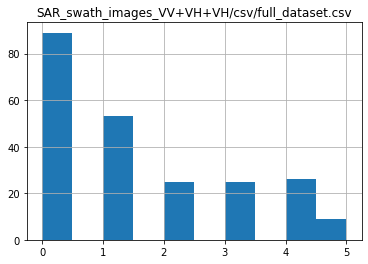

Weights for class 0: 0.43, class 1: 0.71, class 2: 1.51, class 3: 1.51, class 4: 1.46, class 5: 4.20
Entering in k fold cross validation
Dataset dim: 227


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Epoch 1/2
46/46 [==============================] - 14s 168ms/step - loss: 1.9568 - accuracy: 0.2704 - precision: 0.5493 - recall: 0.0475 - tp: 7.9149 - fp: 6.7447 - tn: 951.1277 - fn: 183.6596 - val_loss: 1.8930 - val_accuracy: 0.2174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 229.0000 - val_fn: 46.0000

Epoch 00001: val_loss improved from inf to 1.89299, saving model to SAR_swath_images_VV+VH+VH/classification_results/categorization/ResNet_Numeric-F_BatchSize-8_lr-0.0001_Epochs-44_Folds-5_Norm-T_Aug-T_FineTune-T_from165/best_model_frozen_1.h5
Epoch 2/2
46/46 [==============================] - 5s 108ms/step - loss: 1.7406 - accuracy: 0.1816 - precision: 0.4238 - recall: 0.0059 - tp: 1.5957 - fp: 0.7872 - tn: 957.0851 - fn: 189.9787 - val_loss: 1.8214 - val_accuracy: 0.2609 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 228.0000 - val_fn: 46.0000

Epoch 00002: val_loss improve

KeyboardInterrupt: ignored

In [ ]:
##################################
###          SETTINGS         ####
##################################
main_dir = "SAR_swath_images_VV+VH+VH"
NETWORK = "ResNet"     # options: ["Mobile", "ResNet"]
MIN_HEIGHT = 700
MIN_WIDTH = 400
NUM_VARS = False
NORMALISE = True
ROTATE = False
AUGMENT = True
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 44
FOLDS = 5
LEARNING_RATE = 0.0001
##################################

# STRATIFIED CROSS VALIDATION
def fold_cross_validation(main_dir, NETWORK, MIN_HEIGHT, MIN_WIDTH, NUM_VARS, NORMALISE, ROTATE, AUGMENT, LEARNING_RATE, EPOCHS, BUFFER_SIZE, BATCH_SIZE, SPLIT_NUMBER):

  df = pd.read_csv(main_dir + "/csv/full_dataset.csv", converters={'bbox_shape': eval}).dropna()
  class_weights = helper.compute_class_weights("{}/csv/full_dataset.csv".format(main_dir))

  #Y = df["label"]
  Y = np.zeros(len(df), dtype=int)
  for index, row in df.iterrows():
    if df["label"][index] != 0:
      cat = df["image"][index].split('/')[1]
      Y[index] = int(cat[-1])

  stratified_k_fold = StratifiedKFold(n_splits = SPLIT_NUMBER, random_state = 42, shuffle = False)

  VALIDATION_ACCURACY = []
  VALIDATION_LOSS = []
  VALIDATION_TP = []
  VALIDATION_FP = []
  VALIDATION_TN = []
  VALIDATION_FN = []
  VALIDATION_PRECISION = []
  VALIDATION_RECALL = []

  print("Entering in k fold cross validation")
  print("Dataset dim: {}".format(len(df)))

  # directory to save results
  dir = '{}_Numeric-{}_BatchSize-{}_lr-{}_Epochs-{}_Folds-{}_Norm-{}_Aug-{}_FineTune-T_from165'.format(NETWORK, str(NUM_VARS)[0], str(BATCH_SIZE), str(LEARNING_RATE), str(EPOCHS), str(SPLIT_NUMBER), str(NORMALISE)[0], str(AUGMENT)[0])
  save_dir = main_dir + '/classification_results/categorization/' + dir + '/'
  fold_var = 1
  
  # create an instance of the DataProcessor
  processor = dp.DataProcessor(model = NETWORK,
                               min_height = MIN_HEIGHT,
                               min_width = MIN_WIDTH,
                               normalise = NORMALISE,           # perform normalisation
                               rotate = ROTATE,                 # perform rotation
                               plot_light = False,              # plot only select_crop() images
                               plot_extensive = False,          # plot extensively all images
                               show_prints = False)


  for train_index, val_index in stratified_k_fold.split(np.zeros(len(df)), Y):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]

    train_images, train_labels, train_bbox = helper.load_from_df_with_cat(training_data)
    val_images, val_labels, val_bbox = helper.load_from_df_with_cat(validation_data)
    
    # generate datasets
    train_dataset = helper.prepare_dataset(processor, train_images, train_labels, train_bbox)
    val_dataset = helper.prepare_dataset(processor, val_images, val_labels, val_bbox)

    # configure for performance
    train_dataset = helper.configure_for_performance(train_dataset, BUFFER_SIZE, BATCH_SIZE, shuffle = True, augment = AUGMENT)
    val_dataset = helper.configure_for_performance(val_dataset, BUFFER_SIZE, BATCH_SIZE)

    # create the base pre-trained model
    if NETWORK == "ResNet":
      base_model = models.ResNet50(weights='imagenet', include_top=False, input_shape=(MIN_WIDTH, MIN_HEIGHT, 3))
    elif NETWORK == "Mobile":
      base_model = models.MobileNetV2(weights='imagenet', include_top=False, input_shape=(MIN_WIDTH, MIN_HEIGHT, 3))
    else:
      sys.exit("Incert valid network model. Options: Mobile or ResNet (case sensitive)")

    # Freeze the base_model
    base_model.trainable = False

    inputs = Input(shape=(MIN_WIDTH, MIN_HEIGHT, 3))
    x = base_model(inputs, training = False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(6, activation="softmax")(x)
    model = Model(inputs, outputs)

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer = Adam(learning_rate = LEARNING_RATE), 
                  loss = "categorical_crossentropy",
                  metrics = [CategoricalAccuracy(name="accuracy"), 
                              Precision(name="precision"), Recall(name="recall"), 
                              TruePositives(name='tp'), FalsePositives(name='fp'),
                              TrueNegatives(name='tn'), FalseNegatives(name='fn')])

    # CREATE CALLBACKS
    callbacks = [
        ModelCheckpoint(save_dir + "best_model_frozen_{}.h5".format(str(fold_var)), verbose = 1, save_best_only = True),
        TensorBoard(log_dir = save_dir + "logs/" + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    ]

    initial_epochs = 2

    # train the top layer of the model on the dataset, the weights
    # of the pre-trained network will not be updated during training
    history = model.fit(train_dataset,
                        steps_per_epoch = len(train_dataset),
                        validation_data = val_dataset,
                        validation_steps = len(val_dataset),
                        epochs = initial_epochs,
                        callbacks = callbacks,
                        class_weight = class_weights,
                        shuffle = True)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # unfreeze the whole base model
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 165

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    # recompile the model for the modifications to take effect, with a low learning rate
    model.compile(optimizer = Adam(learning_rate = 1e-5),
                  loss = "categorical_crossentropy",
                  metrics = [CategoricalAccuracy(name="accuracy"), 
                              Precision(name="precision"), Recall(name="recall"), 
                              TruePositives(name='tp'), FalsePositives(name='fp'),
                              TrueNegatives(name='tn'), FalseNegatives(name='fn')])
    base_model.summary()
    
    # adjust callbacks
    callbacks = [
        ModelCheckpoint(save_dir + "best_model_fine_tuned_{}.h5".format(str(fold_var)), verbose = 1, save_best_only = True),
        TensorBoard(log_dir = save_dir + "logs/" + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    ]

    fine_tune_epochs = 10
    total_epochs = initial_epochs + fine_tune_epochs

    # train the entire model end-to-end
    history_fine = model.fit(train_dataset,
                            steps_per_epoch = len(train_dataset),
                            validation_data = val_dataset,
                            validation_steps = len(val_dataset),
                            epochs = total_epochs,
                            initial_epoch = history.epoch[-1],
                            callbacks = callbacks,
                            class_weight = class_weights,
                            shuffle = True)

    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    # PLOT TRAIN/VALIDATION LOSSES
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 10))
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    #plt.ylim([min(plt.ylim()),1])
    ax1.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set(ylabel = "Accuracy",
            title = 'Training and Validation Accuracy')

    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    #plt.ylim([0, 1.0])
    ax2.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    ax2.plot(np.argmin(val_loss), np.min(val_loss), marker="x", color="r", label = "Best model")
    ax2.grid(True)
    ax2.legend(loc='upper right')
    ax2.set(xlabel = 'Epoch', 
          ylabel = 'Cross Entropy',
          title = 'Training and Validation Loss')
    plt.show()
    fig.savefig(save_dir + "model_" + str(fold_var) + ".jpg")
    

    ##################################################################################################
    time.sleep(15) # guarantees enough time so that weights are saved and can be loaded after

    # LOAD BEST MODEL
    print("Loaded best weights of the training")
    model.load_weights(save_dir + "best_model_fine_tuned_{}.h5".format(str(fold_var)))     # Maybe a problem with colab, weights saved and loaded too fast giving concurrency problems

    # EVALUATE PERFORMANCE of the model
    results = model.evaluate(val_dataset, 
                             steps = len(val_dataset), 
                             verbose = 1)

    results = dict(zip(model.metrics_names, results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_TP.append(results["tp"])
    VALIDATION_FP.append(results["fp"])
    VALIDATION_TN.append(results["tn"])
    VALIDATION_FN.append(results["fn"])
    VALIDATION_PRECISION.append(results["precision"])
    VALIDATION_RECALL.append(results["recall"])

    # MAKE PREDICTIONS
    predictions = model.predict(val_dataset)
    predictions_non_category = [ np.argmax(t) for t in predictions ]
    val_labels_non_category = [ np.argmax(t) for t in val_labels ]

    conf_mat = confusion_matrix(val_labels_non_category, predictions_non_category, labels = [0,1,2,3,4,5])
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1,2,3,4,5])
    conf_mat_display = disp.plot()
    plt.savefig(save_dir + "confusion_matrix_" + str(fold_var) + ".jpg")

    tf.keras.backend.clear_session()

    fold_var += 1

    # save the values for each fold
    csv_dir = save_dir + 'csv/'
    os.makedirs(csv_dir, exist_ok=True)
    with open(csv_dir + 'test_accuracy.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_ACCURACY, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_loss.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_LOSS, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_tp.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_TP, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_fp.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_FP, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_tn.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_TN, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_fn.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_FN, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_precision.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_PRECISION, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(csv_dir + 'test_recall.pkl', 'wb') as handle:
        pickle.dump(VALIDATION_RECALL, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return

##################################################################################################
# test
fold_cross_validation(main_dir, NETWORK, MIN_HEIGHT, MIN_WIDTH, NUM_VARS, NORMALISE, ROTATE, AUGMENT, LEARNING_RATE, EPOCHS, BUFFER_SIZE, BATCH_SIZE, FOLDS)

## Test

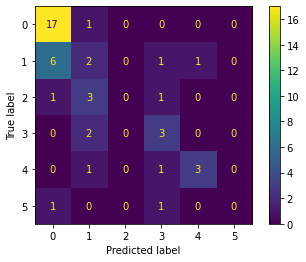

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_labels1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5]
predictions1 =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,3,1,1,1,3,4,0,3,3,3,4,3,3,4,4,4,4,5]

val_labels2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,5,5]
predictions2 =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,1,2,2,2,3,1,1,2,3,3,3,1,1,2,2,3,2,4]

val_labels3 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,4,5]
predictions3 =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,1,1,1,2,2,2,3,4,4,0,0,0,1,2,1,2,2,3,4,1,4,4,4,5,5,4]

val_labels4 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5]
predictions4 =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,1,1,1,1,1,2,3,3,1,1,1,3,3,2,2,3,4,4,1,1,4,4,4,0,3]

val_labels5 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5]
predictions5 =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,3,4,0,1,1,1,3,1,1,3,3,3,1,3,4,4,4,0,3]


val_labels = val_labels1 + val_labels2 + val_labels3 + val_labels4 + val_labels5
predictions = predictions1 + predictions2 + predictions3 + predictions4 + predictions5

conf_mat = confusion_matrix(val_labels5, predictions5, labels = [0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1,2,3,4,5])
conf_mat_display = disp.plot()

import matplotlib.pyplot as plt
#plt.savefig("SAR_swath_images_VV+VH+WS/classification_results/categorization/ResNet_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/global_confusion_matrix.jpg")